In [1]:
import pandas as pd
import numpy as np
import random
import os
from glob import glob
import matplotlib.pyplot as plt
import cv2
import keras
import matplotlib.pylab as plt
import plotly.graph_objects as go

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.notebook_repr_html', True)

In [2]:
path_to_frame = 'K:\DiplomZalevskiy\Data_Entry_2017_v2020.csv'
path_images = os.path.join("K:\DiplomZalevskiy\data\images",'images_00*') # нумерация папок с 1 до конца
# images = glob(os.path.join(path_images,'*.png'))
len([file for file in os.listdir("K:\DiplomZalevskiy\data\images") if file.endswith('.png')])

112120

In [3]:
# тест на чтение датафрейма
df = pd.read_csv('K:\DiplomZalevskiy\Data_Entry_2017_v2020.csv')
df[0:15]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168
6,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,0.143
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168
8,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,0.143
9,00000003_006.png,Hernia,5,3,79,F,PA,2992,2991,0.143,0.143


In [4]:
# перепись датафрейма
def rewrite_dataframe(path_to_frame):
    """
    Импортируем .cvs датафрейм
    Переименуем столбцы таблицы
    Добавить новый столбец, указывающий путь к исходному изображению
    """
    result_dataframe = pd.read_csv(path_to_frame)
    result_dataframe.rename(columns = {'imageindex':'filename'})
    result_dataframe.columns = ['filename','disease','followup','patientID','age','gender',
                                'viewposition','width','height','x','y']
    result_dataframe = result_dataframe.drop(result_dataframe.columns[-1], axis = 1)
    result_dataframe['path'] = 'K:/DiplomZalevskiy/data/images/' + result_dataframe['filename'].replace(' ','')
    return result_dataframe

In [5]:
# проверка на работу переписи
disease_dataframe = rewrite_dataframe(path_to_frame)
disease_dataframe

,filename,disease,followup,patientID,age,gender,viewposition,width,height,x,path
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,K:/DiplomZalevskiy/data/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,K:/DiplomZalevskiy/data/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,K:/DiplomZalevskiy/data/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,K:/DiplomZalevskiy/data/images/00000002_000.png
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,K:/DiplomZalevskiy/data/images/00000003_001.png
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,K:/DiplomZalevskiy/data/images/00030801_001.png
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,K:/DiplomZalevskiy/data/images/00030802_000.png
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,K:/DiplomZalevskiy/data/images/00030803_000.png
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,K:/DiplomZalevskiy/data/images/00030804_000.png


In [6]:
# количество уникальных классов в изначальном датасете
vannila_df = pd.read_csv('K:\DiplomZalevskiy\Data_Entry_2017_v2020.csv')
vannila_df['Finding Labels'].nunique()

836

In [12]:
# количество значений каждой группы
vannila_df['Finding Labels'].value_counts()
single_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
                 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
                 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']
print(vannila_df[vannila_df['Finding Labels'].isin(single_labels)]['Finding Labels'].value_counts())

Infiltration          9547
Atelectasis           4215
Effusion              3955
Nodule                2705
Pneumothorax          2194
Mass                  2139
Consolidation         1310
Pleural_Thickening    1126
Cardiomegaly          1093
Emphysema              892
Fibrosis               727
Edema                  628
Pneumonia              322
Hernia                 110
Name: Finding Labels, dtype: int64


In [17]:
disease_dataframe = disease_dataframe.groupby('disease').filter(lambda x: len(x) > 20 )

In [18]:
# балансировка набора данных
disease_dataframe

,filename,disease,followup,patientID,age,gender,viewposition,width,height,x,path
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,K:/DiplomZalevskiy/data/images/00000001_000.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,K:/DiplomZalevskiy/data/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,K:/DiplomZalevskiy/data/images/00000002_000.png
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,K:/DiplomZalevskiy/data/images/00000003_001.png
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,K:/DiplomZalevskiy/data/images/00000003_002.png
...,...,...,...,...,...,...,...,...,...,...,...
112114,00030801_000.png,No Finding,0,30801,38,M,PA,2500,2048,0.168,K:/DiplomZalevskiy/data/images/00030801_000.png
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,K:/DiplomZalevskiy/data/images/00030802_000.png
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,K:/DiplomZalevskiy/data/images/00030803_000.png
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,K:/DiplomZalevskiy/data/images/00030804_000.png


In [19]:
def create_categorial(df):
    """
    Создадим массив, содержащий фиктивные переменные о каждой болезни
    Добавим столцы, отражающие наличие отдельных болезней, и их пересечение
    Возвращает датафрейм
    """
    disease_labels = ['Atelectasis',
       'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema',
       'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
       'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']
    
    for i in disease_labels:
        df[i] = df.disease.map(lambda result: 1 if i in result else 0)
    df['Crossed Disease'] = df.disease.map(lambda disease: len(disease.split('|')) if '|' in disease else 0 if disease == 'No Finding' else 1)
    df['array_disease'] = df[disease_labels].apply(lambda x: x.tolist(),axis=1)
    return df

In [20]:
fixed_final_df = create_categorial(disease_dataframe)
#

In [23]:
fixed_final_df['disease'].value_counts()[0:15]
fixed_final_df[fixed_final_df.disease.isin(disease_labels)].disease.value_counts()

Infiltration          9547
Atelectasis           4215
Effusion              3955
Nodule                2705
Pneumothorax          2194
Mass                  2139
Consolidation         1310
Pleural_Thickening    1126
Cardiomegaly          1093
Emphysema              892
Fibrosis               727
Edema                  628
Pneumonia              322
Hernia                 110
Name: disease, dtype: int64

In [15]:
# сохраняем полученный датафрейм
fixed_final_df.to_pickle('ZalevskiyDiplom/dataframes/fixed_final_df.pkl')

In [59]:
from sklearn.model_selection import train_test_split

# СОЗДАНИЕ ВЫБОРОК : ОБУЧЕНИЯ, ВАЛИДАЦИЯ, ТЕСТИРУЮЩАЯ

train_set, valid_set = train_test_split(fixed_final_df, 
                                        train_size=0.9, 
                                        random_state=42, 
                                        #stratify=fixed_final_df.disease
                                        shuffle=True) 



train_set, test_set = train_test_split(train_set, 
                                       test_size=0.20, 
                                       random_state=42, 
                                       #stratify=train_set.disease
                                       shuffle=True) 

print('Разбиение данных:')
print('Обучающая выборка: ', train_set.shape[0])
print('Валидационная выборка: ', valid_set.shape[0])
print('Тестирующая выборка: ', test_set.shape[0])
print('Общее число записей:', fixed_final_df.shape[0])

Разбиение данных:
Обучающая выборка:  78895
Валидационная выборка:  10958
Тестирующая выборка:  19724
Общее число записей: 109577


In [94]:
train_set

,filename,disease,followup,patientID,age,gender,viewposition,width,height,x,path,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,Crossed Disease,array_disease
80802,00019861_018.png,No Finding,7,19861,63,M,AP,2500,2048,0.168,K:/DiplomZalevskiy/data/images/00019861_018.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
110035,00029943_016.png,Effusion,16,29943,65,F,AP,3056,2544,0.139,K:/DiplomZalevskiy/data/images/00029943_016.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
29653,00007718_006.png,Atelectasis|Effusion,6,7718,58,F,PA,2048,2500,0.168,K:/DiplomZalevskiy/data/images/00007718_006.png,1,0,0,0,0,0,0,1,0,0,0,0,0,0,2,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
72184,00017762_005.png,No Finding,4,17762,14,F,PA,2992,2991,0.143,K:/DiplomZalevskiy/data/images/00017762_005.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
40562,00010537_000.png,Atelectasis,0,10537,27,F,PA,2992,2991,0.143,K:/DiplomZalevskiy/data/images/00010537_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6125,00001654_005.png,Infiltration,4,1654,55,F,PA,2706,2991,0.143,K:/DiplomZalevskiy/data/images/00001654_005.png,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
31690,00008291_003.png,No Finding,3,8291,33,F,AP,2500,2048,0.168,K:/DiplomZalevskiy/data/images/00008291_003.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
33198,00008701_041.png,No Finding,41,8701,46,F,AP,2500,2048,0.168,K:/DiplomZalevskiy/data/images/00008701_041.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
82138,00020211_000.png,No Finding,0,20211,18,M,PA,3056,2488,0.139,K:/DiplomZalevskiy/data/images/00020211_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [51]:

# labels_disease = labels[1:14]
# train_values = train_counts
# valid_values = valid_counts
# test_values = test_counts
# fig = go.Figure()

# fig.add_trace(go.Scatter(x=labels_disease, y=train_values,name='Обучающая'))
# fig.add_trace(go.Scatter(x=labels_disease,y=valid_counts,name='Валидационная'))
# fig.add_trace(go.Scatter(x=labels_disease,y=test_counts,name='Тестовая'))
# templates = ['ggplot2', 'seaborn', 'simple_white', 'plotly',
#          'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
#          'ygridoff', 'gridon', 'none']
# fig.update_layout(yaxis_title='Количество случаев',xaxis_title='Болезни',barmode='stack', template = 'seaborn', 
#                   title = 'Графики полученных выборок')
# fig.show()

In [74]:
train_counts = train_set.disease.value_counts()
train_counts

No Finding                           43341
Infiltration                          6880
Atelectasis                           3032
Effusion                              2915
Nodule                                1937
                                     ...  
Edema|Infiltration|Mass                 14
Cardiomegaly|Nodule                     13
Effusion|Infiltration|Mass|Nodule       13
Consolidation|Edema|Infiltration        12
Effusion|Emphysema|Infiltration         12
Name: disease, Length: 145, dtype: int64

In [93]:
labels = train_set.disease.value_counts().keys()
train_counts = train_set.disease.value_counts()
valid_counts = valid_set.disease.value_counts()
test_counts = test_set.disease.value_counts()
fig = go.Figure(data=[
    go.Bar(name='Обучающая часть', x=labels[1:14],marker_color='lightseagreen',
           y=train_counts[1:14]),
    go.Bar(name='Валидационная часть', x=labels[1:14],marker_color='lightblue',
           y=valid_counts[1:14]),
    go.Bar(name='Тестирующая часть', x=labels[1:14],marker_color='lightcoral',
           y=test_counts[1:14])
])
# Change the bar mode
fig.update_layout(yaxis_title='Количество случаев',xaxis_title='Болезни',
                  legend=dict(x=.5, xanchor="center"),barmode='stack', template = 'plotly_white', 
                  title = 'Разбиение датафрейма на выборки')
fig.show()


In [97]:
def saving_data(path,train_set,valid_set,test_set):
    '''
    Сохраняет данные в формате .pkl по указанному пути
    '''
    if not os.path.exists(path):
        os.makedirs(path)
    train_set.to_pickle(path + '/' + 'new_train_set.pkl') 
    valid_set.to_pickle(path + '/' + 'new_valid_set.pkl') 
    test_set.to_pickle(path + '/' + 'new_test_set.pkl') 

In [98]:
saving_data('ZalevskiyDiplom/sample',train_set,valid_set,test_set)


In [34]:
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168


In [60]:
test_df = df.copy()

In [67]:
test_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168


In [65]:
result_df = df.copy()
for filename,index in zip(df['Image Index'],range(112200)):
    if os.path.exists(f'K:/DiplomZalevskiy/data/images/{filename}') == False:
        
        result_df = result_df.drop(index = index)
        print(filename,index)
    #print(index, filename, True if os.path.exists(f'K:/DiplomZalevskiy/data/images/{i}') else False)

00000001_000.png 0
00000001_001.png 1
00000001_002.png 2
00000002_000.png 3


In [66]:
result_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168
6,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,0.143
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168
8,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,0.143
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168


In [9]:
import numpy as np
import cv2
def sharpering(img):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    return image_sharp

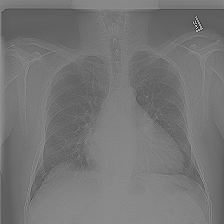

In [17]:
from keras.preprocessing import image
from tensorflow.keras.utils import load_img,img_to_array,array_to_img
import glob
import cv2

img = load_img(r'K:\DiplomZalevskiy\data\test.png',target_size=(224,224))
x = img_to_array(img)
sharp_img = sharpering(x)
res = array_to_img(sharp_img)
res

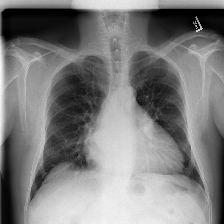

In [20]:
img = load_img(r'K:\DiplomZalevskiy\data\test.png',target_size =(224,224))
x = img_to_array(img)
img